In [1]:
import os
import tqdm
import torch
import torchvision
from deepface import DeepFace
from lib import Autoencoder, FacesDataset, NoiseScheduler,unet, Demorpher

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cpu


In [3]:
encoder = torchvision.models.vgg16(pretrained=False) # autoencoder shape
encoder = encoder.features[:11]

autoencoder = Autoencoder(encoder)
autoencoder.load_state_dict(torch.load('ae_Casia_30.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
batch_size = 1

In [5]:
diffusion = unet(1)
diffusion.load_state_dict(torch.load('diffusion_65.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
torch.load('diffusion_65.pth',map_location=torch.device('cpu'))

OrderedDict([('time_proj.0.weight',
              tensor([[-2.2432, -1.4792,  2.5163,  ...,  1.3699,  1.2380,  1.3826],
                      [-3.9403,  2.0248,  3.8196,  ..., -4.0609, -3.9692, -3.9967],
                      [-2.2129, -3.2500, -3.3530,  ..., -2.2897, -2.2016, -2.2926],
                      ...,
                      [-3.9589, -3.8776, -1.5759,  ..., -2.3244, -2.3218, -2.4487],
                      [ 2.3474,  3.2609, -2.1732,  ...,  3.3600,  3.3147,  3.3709],
                      [ 2.3129,  2.2969,  2.2297,  ..., -3.3078, -3.2749, -3.4141]])),
             ('time_proj.0.bias',
              tensor([ 1.3212, -3.9996, -2.3531, -3.1687,  2.3999,  3.2086,  3.2794, -3.9099,
                       3.2240,  3.2607, -2.3146, -3.7761, -4.1935, -3.9910, -2.2585, -3.2224,
                      -2.3296,  0.4070, -2.2059, -2.3332, -3.6931, -3.7254,  2.2806, -2.2655,
                      -2.2846, -2.0621, -2.3014, -2.2603, -1.8558,  2.2801,  3.3989, -2.2675,
                    

In [7]:
scheduler = NoiseScheduler(0.01,0.05,20) 

In [8]:
model = Demorpher(autoencoder.get_encoder(), autoencoder.get_decoder(), diffusion,scheduler)
model.eval() ; 

In [9]:
#FacesDataset = FacesDataset("Dataset/Neutral_Brightness", "Dataset/Morphed_Val_Brightness")
#FacesDataset = FacesDataset("Dataset/Neutral_Brightness", "Dataset/TEST_ON_TRAIN")
FacesDataset = FacesDataset("Dataset/Neutral_Brightness", "Dataset/TEST_ON_BONAFIDE")

Found 1269 identities.


In [10]:
im_a,im_id,im_b, paths = FacesDataset[0]
im_a = im_a.unsqueeze(0).float().to(device)
im_id = im_id.unsqueeze(0).float().to(device)

In [11]:
im_a.shape

torch.Size([1, 3, 224, 224])

In [12]:
im_idout = model(im_a,im_id)

z_ID nan:  tensor(False)
 z_A nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)
noise nan:  tensor(False)


In [13]:
im_idout

tensor([[[[0.0799, 0.1290, 0.1800,  ..., 0.8111, 0.6294, 0.4585],
          [0.0805, 0.1282, 0.1680,  ..., 0.7721, 0.5105, 0.3330],
          [0.0752, 0.1270, 0.1755,  ..., 0.6897, 0.3919, 0.1895],
          ...,
          [0.9345, 1.4164, 2.0334,  ..., 1.0445, 1.1850, 1.2745],
          [0.3695, 0.8804, 1.8998,  ..., 1.0533, 1.2444, 1.3189],
          [0.0957, 0.8164, 1.6150,  ..., 0.9217, 1.1247, 1.1257]],

         [[0.0858, 0.0862, 0.0830,  ..., 0.8428, 0.6084, 0.4077],
          [0.0832, 0.0939, 0.0829,  ..., 0.7543, 0.5099, 0.3209],
          [0.0716, 0.0994, 0.1098,  ..., 0.5981, 0.4118, 0.1996],
          ...,
          [1.0967, 2.0299, 1.2714,  ..., 1.0161, 1.0786, 1.1341],
          [0.5478, 0.6911, 1.3581,  ..., 0.9711, 1.0128, 1.1345],
          [0.3257, 0.6654, 0.8067,  ..., 0.8422, 1.0469, 1.0341]],

         [[0.0918, 0.1049, 0.1186,  ..., 0.8511, 0.6165, 0.3993],
          [0.0867, 0.1095, 0.1244,  ..., 0.8564, 0.5134, 0.3517],
          [0.0784, 0.1001, 0.1386,  ..., 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.917754..22.0733].


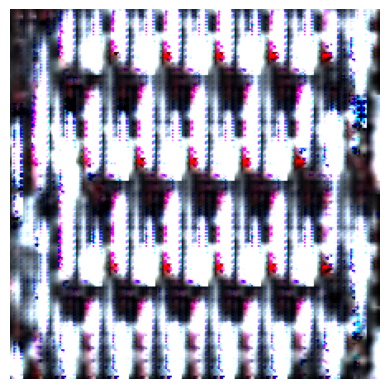

In [14]:
import matplotlib.pyplot as plt

plt.imshow(im_idout.squeeze().permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.show()

In [ ]:
out = DeepFace.verify( img1_path = im_b.detach().numpy(), img2_path = im_idout.detach().numpy(), threshold=0.5)
out2 = DeepFace.verify( img1_path = im_a.detach().numpy(), img2_path = im_idout.detach().numpy(), threshold=0.5)

In [ ]:
out

In [ ]:
out2

In [ ]:
for im_a,im_id,im_b, paths in tqdm(FacesDataset):
    im_idout = model(im_a,im_id)
    out = DeepFace.verify( img1_path = im_b, img2_path = im_idout, threshold=0.5)
    